I'm broadeneing the scope of my species selection to include birds and maybe some aquatic species. It is limited to euaryotic vertebrates at this point, rather than just mammals becuase that seemed really boring to me. Of course the majority of mammal species are going to have a lot of proteins in common, they're mammals. -4/14

<br>
I am removing the California two-spotted octopus from my data set, because as the only invertebrate it was throwing off my data a lot and consistently being completely disconnected from the network. It makes sense why, because they're invertebrates and also they have some strange ability to alter their own DNA at the individual level. So, even though I think they're really cool, I'm removing them. Without the octopus I've managed to produce two fully connected projections but it took many runs of the random protein code to do so. Please do not run the randomized protein selection cell again unless you absolutely have to. I added some files with this specific protein-species collection and wrote a cell to read them in, that way it won't get randomized any time I need to restart the kernel. -4/19
<br>
I am functionalizing basically everything, so update to 4/19, you shouldnt need to worry about running the cell again as I wont be calling that function. -4/21
<br>
I am going to implement a topological edge prediction algorithm (specifically on the protein-protein projection of my network) and see if I can predict a species that actually has those proteins. I won't be able to derive a quantitave AUC for my predictions, but I'm hoping to be able to report on a more qualitative measure of accuracy. I'm going to implement both Jaccard and degree product edge prediction. I expect Jaccard to be better because this network displays some level of community structure which Jaccard can take advantage of in a way degree product cannot. 4/27
<br>
After a full nights rest, all of today is dedicated to bionets. Lets predict some missing species and talk about evolutionary interactions! Well, I've made predictions and I was really dissapointed at first that the majority of my highest scoring predicted edges are between primate proteins (feels boring and kind of like, duh...) but when I complained about my lack of excitement over my findings to a friend, they said to me "why do you not like it? it just sounds like you did a good job idk". And when I think about it, they're right. I've used the protein-protein projection to create links between missing species and existing species within my network, and the fact that the proteins from primates are likely to have a common neighbor (probably a missing primate) is cool. It might not tell me something I didn't already know about evolutionary relationships, but indpendent of that evolutionary data it backs up existing knowledge, which is pretty neat. Degree product is terrible and the stinky pigeon has basically taken over. It has a seemingly high degree and just overpowers everything else. I might just remove degree product entirely.  -4/28



In [1]:
import gzip  #for interacting with .gz files
#https://docs.python.org/3/library/gzip.html
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline


In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 200
    flabel = False

    
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=1,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs-', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

In [4]:
def get_species():
    os.chdir(r"C:/Users/Kai/Documents/2020-SP/CSCI 3352/Project/BioNets/data")
    
    files = []
    for (dirpath, dirnames, filenames) in os.walk("."):
        for name in filenames:
            b = name.startswith("specs") or name.startswith("prots")
            if not b:
                files.append(name)
        break
    #print(files)
    
    
    species_smash = []
    for name in files:
        temp = []
        with gzip.open(name, 'rt') as f:
            for line in f:
                temp.append(line[:-1])
        species_smash.append(temp)
    
    penguin, african_elephant, black_bear, crow, bonobo, hamster, ferret, woodpecker, platypus, bushbaby, golden_monkey, gouldian_finch, sea_turtle, human, bat, pig, polar_bear, rat, rock_dove, tasmanian_devil, hedgehog, gorilla, river_dolphin, zebra_finch = (species_smash[i] for i in range(24))
     
    all_species = [bat, ferret, sea_turtle, platypus, human, bonobo, tasmanian_devil, hedgehog, rat, hamster, gorilla, bushbaby, polar_bear, black_bear, penguin, river_dolphin, crow, gouldian_finch, zebra_finch, woodpecker, rock_dove, golden_monkey, pig, african_elephant]
    all_species2 = [bat, ferret, tasmanian_devil, hedgehog, rat, hamster, bushbaby, polar_bear, black_bear, penguin, river_dolphin, golden_monkey, pig, african_elephant]
                
        
    return all_species

pick 100 random proteins (four from each species, so each species node will have at least four edges)<br>
denote proteins somehow - "species name, gene name, location within source"?<br>
bipartite network!!<br>
run through all_proteins, run through all_species, if given protein exists within species, create edge)<br>


In [6]:
'''THIS IS RANDOMIZED!! Dont run it again 
unless you want to change the entire network!'''

def choose_proteins_random(all_species):
    proteins = {}
    spec_names = []
    for species in all_species:
        line = species[0]
        #print(line)
        op = line.index('(')
        cl = line.index(')')
        spec_name = line[op+1:cl].lower()

        #print(spec_name)
        #print(species[:50])
        prots = np.random.choice(species, 4, replace=False)
        #print(prots)
        for protein in prots:
            while protein.startswith('>'):
                #print('redraw')
                protein = np.random.choice(species, replace=False)
            i = species.index(protein)
            j=i
            found = False
            while i > 0 and found == False:
                line = species[i]
                if line.startswith('>'):
                    #print(species[i])
                    #op = line.index('(')
                    #cl = line.index(')')
                    g = line.index('GN=')
                    #spec_name = line[op+1:cl].lower()
                    if spec_name == 'small-eared galago': # these names were just too far from what i was calling them
                        spec_name = 'bushbaby'
                    if spec_name == 'pygmy chimpanzee':
                        spec_name = 'bonobo'
                    gene_name = line[g+3:]
                    en = gene_name.index(' ')
                    gene_name = gene_name[:en]
                    prot_ref = j-i
                    proteins[str(spec_name) + ' ' + str(gene_name) + ' ' + str(prot_ref)] = protein
                    if spec_name not in spec_names:
                        spec_names.append(spec_name)
                    found = True
                i-=1
    #print(all_proteins_temp)    
    all_proteins = proteins
    #print(len(all_proteins))
    #print(all_proteins)
    return (all_proteins, spec_names)


In [7]:
'''THIS WRITES THE PROTEINS AND SPECIES TO A FILE'''

#https://stackoverflow.com/questions/36965507/writing-a-dictionary-to-a-text-file
def write_prots_species_to_file(all_proteins, spec_names, network):
    if network == 1:
        with open('prots.txt', 'w') as f:
            print(all_proteins, file=f)
        with open('specs.txt', 'w') as f:
            for item in spec_names:
                f.write('%s\n' % item)
    elif network == 2:
        with open('prots2.txt', 'w') as f:
            print(all_proteins, file=f)
        with open('specs2.txt', 'w') as f:
            for item in spec_names:
                f.write('%s\n' % item)

In [8]:
'''THIS READS THE PROTEINS AND SPECIES IN FROM A FILE'''


def read_prots_species_from_file(network):
    #https://stackoverflow.com/questions/36965507/writing-a-dictionary-to-a-text-file
    if network == 1:
        with open('prots.txt', 'r') as f: 
            content = f.read()
            all_proteins = eval(content)


        spec_names = []
        with open('specs.txt', 'r') as f:
            for line in f:
                # remove linebreak which is the last character of the string
                spec = line[:-1]

                # add item to the list
                spec_names.append(spec)

        return(all_proteins, spec_names)
    elif network == 2:
        with open('prots2.txt', 'r') as f: 
            content = f.read()
            all_proteins = eval(content)


        spec_names = []
        with open('specs2.txt', 'r') as f:
            for line in f:
                # remove linebreak which is the last character of the string
                spec = line[:-1]

                # add item to the list
                spec_names.append(spec)

        return(all_proteins, spec_names)
# all_prots, spec_names = read_prots_species_from_file()

In [9]:

def lowercase_species_name(all_species, spec_names):
    #all_specs = []
    #print(all_species[50:])
    for i in range(len(all_species)):
        species_low = all_species[i][0].lower() #the first index of the file contains the species name, im lowercasing it
        #print(species_low)                     #then im adding those lowercase names to the species' data 
        for name in spec_names:                 #so that when i check for protein-species connections later, it catches the right data
            if name in species_low:             
                all_species[i] = [name] + all_species[i]
    #print(all_species[50:])
    return all_species
                #print(species[0:2])
        #all_specs.append(species)

    #
    
    #all_species = [bat, ferret, sea_turtle, platypus, human, bonobo, tasmanian_devil, hedgehog, rat, hamster, gorilla, bushbaby, polar_bear, black_bear, penguin, river_dolphin, crow, octopus, gouldian_finch, zebra_finch, woodpecker, rock_dove, golden_monkey, pig, african_elephant]



In [10]:
def build_species_protein_net(spec_names, all_proteins, all_species):
    #https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html
    spec_prot_net = nx.Graph()
    spec_prot_net.add_nodes_from(spec_names, bipartite=0)
    spec_prot_net.add_nodes_from(all_proteins.values(), bipartite=1)
    top_nodes = {n for n, d in spec_prot_net.nodes(data=True) if d['bipartite']==0}
    bottom_nodes = set(spec_prot_net) - top_nodes

    spec_prot_edges = []
    for species in all_species:
        #print(species[0])
        for prot_node in bottom_nodes:
            for spec_node in top_nodes:
                #print(species[0])
                if spec_node == species[0]: # and prot_node in species:
                    for item in species:
                        if prot_node == item:
                    #print("YAAYYYYYYY")
                            #print(prot_node, item)
                            spec_prot_edges.append([spec_node, prot_node])
                            break
                    #print(spec_prot_edges)
    #print(len(list(set(spec_prot_edges))))
    #print(edges)
    
    #print(spec_prot_edges)

    spec_prot_net.add_edges_from(spec_prot_edges)
    #https://stackoverflow.com/questions/27084004/bipartite-graph-in-networkx
    #https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html
    
    
    #print(spec_prot_edges)
    dr = nx.bipartite_layout(spec_prot_net, top_nodes) 
    return (spec_prot_net, spec_prot_edges, dr, top_nodes, bottom_nodes)
    #       s_p_net,       s_p_edges,       dr, top_nodes, bottom_nodes 

make species-species interaction network<br>
make protein-protein interaction network<br>
talk about them?
idk what comes after that??


In [11]:
def create_spec_net(spec_names, spec_prot_edges): 
    specnet = nx.Graph()
    specnet.add_nodes_from(spec_names)
    spec_edges = []
    #print(spec_prot_edges)
    for edge in spec_prot_edges:
        neigh = edge[1]
        for edgy in spec_prot_edges:
            if edgy[1] == neigh and edgy[0] != edge[0]:
                spec_edges.append((edge[0], edgy[0]))
    specnet.add_edges_from(spec_edges)
    #print(spec_edges)
    return specnet
        



In [12]:
def create_prot_net(all_proteins, spec_prot_edges):
    protnet = nx.Graph()
    protnet.add_nodes_from(all_proteins.values())
    prot_edges = []

    for edge in spec_prot_edges:
        neigh = edge[0]
        for edgy in spec_prot_edges:
            if edgy[0] == neigh and edgy[1] != edge[1]:
                #print(edge[1])
                prot_edges.append((edge[1], edgy[1]))
    protnet.add_edges_from(prot_edges)
    #print(prot_edges)
    
    
    return protnet
    

In [13]:
def predict_edges_Jaccard(net, i, j):
    #Jaccard(i, j) = |ν(i) ∩ ν(j)|/|ν(i) ∪ ν(j)|
    #jaccard(i, j) = num common neighbors (in both) / neighbors in either (or both, but dont double count!)
    #score(i, j) = Jaccard(i, j) + Uniform(0, eps) where eps = 1/num nodes im pretty sure (small enough to never change ordering)
    ineighs = set(net.neighbors(i))
    jneighs = set(net.neighbors(j))
    both = len(ineighs.intersection(jneighs))
    #print(both)
    either = len(ineighs.union(jneighs))
    jacc = both/either
    eps = 1/net.number_of_nodes()
    score = jacc + np.random.uniform(0, eps)
    return score
    #pass

In [14]:
def predict_edges_degree_prod(net, i, j):
    #score(i, j) = k_i*k_j + Uniform(0, eps) where k_i is the degree count of node i
    ineighs = list(net.neighbors(i))
    jneighs = list(net.neighbors(j))
    prod = len(ineighs)*len(jneighs)
    eps = 1/net.number_of_nodes()
    score = prod + np.random.uniform(0, eps)
    return score
    #pass

In [15]:
def tabulate_scores(net):
    Jscores = []
    dpscores = []
    addedJ = []
    addeddp = []
    for i in net.nodes():
        for j in net.nodes():
            if i != j:
                if (i, j) not in addedJ and (j, i) not in addedJ:
                    Jscores.append([(i, j), predict_edges_Jaccard(net, i, j)])
                    addedJ.append((i, j))
                if (i, j) not in addeddp and (j, i) not in addeddp:
                    dpscores.append([(i, j), predict_edges_degree_prod(net, i, j)])
                    addeddp.append((i, j))
    #https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/
    Jsorted = sorted(Jscores, key = lambda x: x[1], reverse = True)
    dpsorted = sorted(dpscores, key = lambda x: x[1], reverse = True)
    return(Jsorted, dpsorted)

In [16]:
#this just gets the info on the species the proteins in question came from, for my own research and benefit
def high_scoring_scpecies(all_prots, Jacc_out, dp_out):
    outputJ = []
    outputdp = []
    for prot in Jacc_out:
        temp = []
        for item in all_prots:
            #print(prot[0][0], all_prots[item])
            if prot[0][0] == all_prots[item]:
                temp.append((item, all_prots[item]))
            if prot[0][1] == all_prots[item]:
                temp.append((item, all_prots[item]))
        if len(temp) > 1:
            outputJ.append(temp)
    
    for prot in dp_out:
        temp = []
        for item in all_prots:
            if prot[0][0] == all_prots[item]:
                temp.append((item, all_prots[item]))
            if prot[0][1] == all_prots[item]:
                temp.append((item, all_prots[item]))
        if len(temp) > 1:
            outputdp.append(temp)
    
    return (outputJ, outputdp)
                
    

Species-Protein bipartite network
Blue - Species, Red - Protein


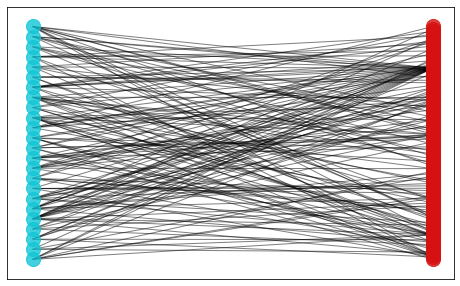

Species-Species projection network


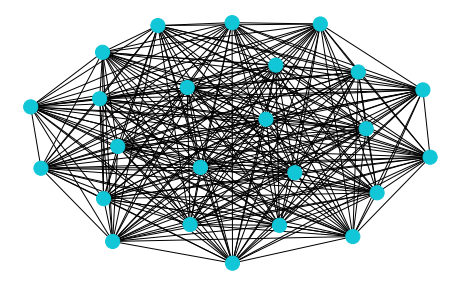

Protein-Protein projection network


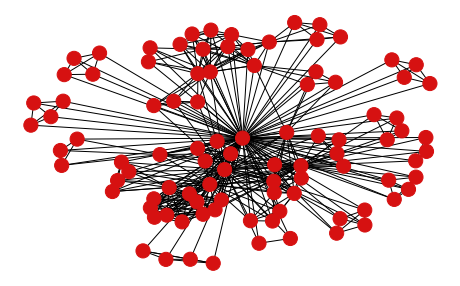

Species-Protein bipartite network CCDF


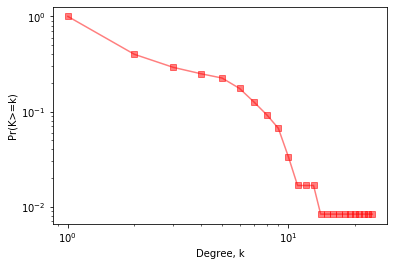

Species-Species projection network CCDF


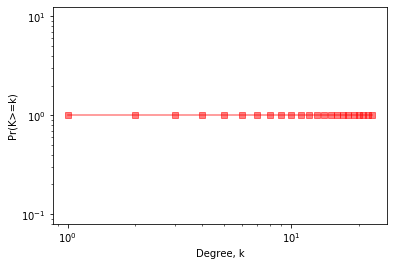

Protein-Protein projection network CCDF


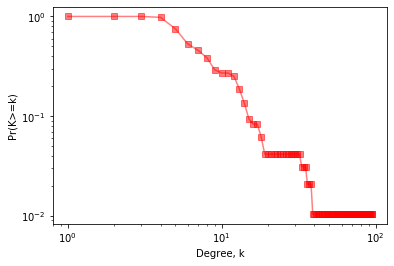

In [17]:
def main():
    all_specs = get_species()
    
    '''these are the randomized function calls'''
    #all_prots, spec_names = choose_proteins_random(all_specs)
    #write_prots_species_to_file(all_prots, spec_names, 2)
    
    
    
    
    
    
    all_prots, spec_names = read_prots_species_from_file(1) #this takes argument 1, or 2 specifiying whether you want the original network
    #print(spec_names)                                  #or the more specific one based on my original findings
    all_specs = lowercase_species_name(all_specs, spec_names)
    #print('all spec', all_specs[50:])
    s_p_net, s_p_edges, dr, top_nodes, bottom_nodes = build_species_protein_net(spec_names, all_prots, all_specs)
    #print(dr)
    #print(s_p_edges)
    s_net = create_spec_net(spec_names, s_p_edges)
    p_net = create_prot_net(all_prots, s_p_edges)
    
    
    
    
    
    '''drawing the networks'''
    '''see final write up for details'''
    
    plt.figure(figsize = (8, 5)) 
    nx.draw_networkx_nodes(s_p_net, dr,
                       nodelist=top_nodes,
                       node_color='#11c6d6',
                       node_size=200,
                       alpha=0.8)
    nx.draw_networkx_nodes(s_p_net, dr,
                           nodelist=bottom_nodes,
                           node_color='#d61111',
                           node_size=200,
                           alpha=0.8)

    # edges
    
    #print(s_p_edges)
    nx.draw_networkx_edges(s_p_net, dr, edgelist=s_p_edges, width=1.0, alpha=0.5)
    print("Species-Protein bipartite network\nBlue - Species, Red - Protein")
    plt.show()

    #nx.draw_networkx(spec_prot_net, dr)
    
    
    z = {}
    for i in s_net.nodes(): 
        z[i] = 1
    #plt.subplot(222)
    
    plt.figure(figsize = (8, 5)) 
    print("Species-Species projection network")
    drawGz(s_net, z)
    for i in p_net.nodes(): 
        z[i] = 0
    #plt.subplot(223)
    
    plt.figure(figsize = (8, 5)) 
    print("Protein-Protein projection network")
    drawGz(p_net, z)
    
    #print(len(list(p_net.neighbors('K'))))
    Jacc_out, dp_out = tabulate_scores(p_net)
    #print('Jaccard scores: \n', Jacc_out[:10], '\n')
    #print('degree product scores: \n', dp_out[:10], '\n')
    
    Jacc_spec, dp_spec = high_scoring_scpecies(all_prots, Jacc_out, dp_out)
    
    
    
    spdegs = s_p_net.degree()
    spde = []
    for node in spdegs:
        spde.append(node[1])
        
    sdegs = s_net.degree()
    sde = []
    for node in sdegs:
        sde.append(node[1])
        
    pdegs = p_net.degree()
    pde = []
    for node in pdegs:
        pde.append(node[1])
    
    print("Species-Protein bipartite network CCDF")
    plot_CCDF(spde)
    print("Species-Species projection network CCDF")
    plot_CCDF(sde)
    print("Protein-Protein projection network CCDF")
    plot_CCDF(pde)
    
main()